In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import os
import shutil
import folium
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns
import math
import stats
import scipy

# Data

In [2]:
# importing all files including the shapes
geo = gpd.read_file('wdl_data/m_risk_prfile.geojson')
df = pd.DataFrame(geo).drop(columns=['geometry', 'Link_ID'])

In [3]:
# df.describe()

In [4]:
geo.nunique(), df.shape
## Linkid is a unique identifier for the dataset

(Link_ID       34678
 linkid        34678
 Daily_Aver    34077
 Average_Ve    32726
 Median_of_     3621
 First_Quar     2807
 Third_Quar     2808
 Func_Class        3
 Speed_Cat         6
 geometry      34673
 dtype: int64,
 (34678, 8))

**Note**<br>
There are **34678** unique road segments in the data set.

In [5]:
# calculating length of lines with epsg:5018 for Lisbon (~2m accuracy)
## further investiagation: GCS_WGS_1984 -- is written in the files
tot_l = geo.geometry.to_crs(epsg=5018).length.sum()
print(f'the road segments provided in data have a total length of \n{round(tot_l, 2)} m \n{round(tot_l/1000, 2)} km')

the road segments provided in data have a total length of 
2969289.43 m 
2969.29 km


In [6]:
## Filtering only lisbon data at 38.72526068747401, -9.142352617846093
circle_lisbon = shapely.geometry.Point(-9.142352617846093, 38.72526068747401).buffer(1)
geo_lis = geo[geo.geometry.within(circle_lisbon)]

In [7]:
geo_lis.linkid
# left 17.688 shapes in the df

0          80216819
1          80216858
2          80216859
3          80216860
4          80216867
            ...    
17683    1223441896
17684    1223441897
17685    1223525691
17686    1223525692
17687    1223731270
Name: linkid, Length: 17688, dtype: int64

In [8]:
## looking for speed cat specs
df.Speed_Cat.describe()

count    34678.000000
mean         4.904781
std          1.520568
min          2.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: Speed_Cat, dtype: float64

In [9]:
# manually accessing the geodata (without gpd)
with open('wdl_data/m_risk_prfile.geojson') as f:
    geol = json.load(f)
    


In [10]:
geo.columns

Index(['Link_ID', 'linkid', 'Daily_Aver', 'Average_Ve', 'Median_of_',
       'First_Quar', 'Third_Quar', 'Func_Class', 'Speed_Cat', 'geometry'],
      dtype='object')

In [11]:
# charts = ["Statistics", "Results 2018"]

# ## TESTPLOT
# @interact(tiles=charts)
def create_map(circle_lisbon=circle_lisbon, geol=geol):
    m = folium.Map([38.74288, -9.16624])

    folium.Choropleth(geo_data=circle_lisbon, 
                      name="Circle", 
                      fill_color="yellow", 
                      fill_opacity=.3, 
                      show=False).add_to(m)

    # roads by speed cat
    roads = folium.map.FeatureGroup(name='Roads')
    cmap = matplotlib.cm.get_cmap('coolwarm')
    norm = matplotlib.colors.Normalize(vmin=2, vmax=6)

    for feat in geol['features']:
        coords = feat['geometry']['coordinates'][0]
        # flipping lat, lng
        _co = [[co[1], co[0]] for co in coords]
        speed = feat['properties']['Speed_Cat']
        rgba = cmap(norm(speed))
        hexa = matplotlib.colors.to_hex(rgba)
        folium.PolyLine(_co, color=hexa, opacity=1, weight=4).add_to(roads)

    roads.add_to(m)

    folium.LayerControl().add_to(m)

    return m

In [ ]:
# create_map()

# Cleaning and inspecting the data

In [13]:
# change column names
df_ren = df.rename(columns={
                    'Daily_Aver':'Daily_Average_Traffic_Intensity',
                    'Average_Ve':'Average_Velocity_of_Vehicle_Traffic',
                    'Median_of_':'Median_of_velocity_of_Vehicle_Traffic',
                    'First_Quar': 'FirstQuartil_of_velocity_of_Vehicle_Traffic',
                    'Third_Quar': 'ThirdQuartil_of_velocity_of_Vehicle_Traffic'
                })

In [14]:
df_ren.dtypes

linkid                                           int64
Daily_Average_Traffic_Intensity                float64
Average_Velocity_of_Vehicle_Traffic            float64
Median_of_velocity_of_Vehicle_Traffic          float64
FirstQuartil_of_velocity_of_Vehicle_Traffic    float64
ThirdQuartil_of_velocity_of_Vehicle_Traffic    float64
Func_Class                                       int64
Speed_Cat                                        int64
dtype: object

In [15]:
# remove outliers
def rm_out(df):
    for i in df.columns.drop(['linkid', 'Daily_Average_Traffic_Intensity']):
        lb = 0
        ub = 180
#         print(lb, ub)
        df[i] = df[i].mask(df[i] < lb) 
        df[i] = df[i].mask(df[i] > ub) 
    return df

df_cl = rm_out(df_ren)
# df_cl

In [16]:
df_cl.describe()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
count,3.467800e+04,34678.000000,34633.000000,34675.000000,34677.000000,34674.000000,34678.000000,34678.000000
mean,8.958206e+08,3340.417942,56.112805,56.402803,43.834624,67.959767,2.684613,4.904781
std,2.355910e+08,2725.873982,24.346245,25.054113,24.329987,26.706718,0.538658,1.520568
min,8.021682e+07,14.435864,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
25%,7.364832e+08,1903.398108,38.317003,38.250000,26.000000,48.000000,2.000000,4.000000
50%,9.067377e+08,2644.529317,49.961538,50.000000,38.875000,60.333333,3.000000,6.000000
75%,1.154997e+09,3897.886608,69.447459,71.000000,56.000000,85.000000,3.000000,6.000000
max,1.223731e+09,49309.806935,179.691892,143.250000,143.000000,164.000000,3.000000,7.000000


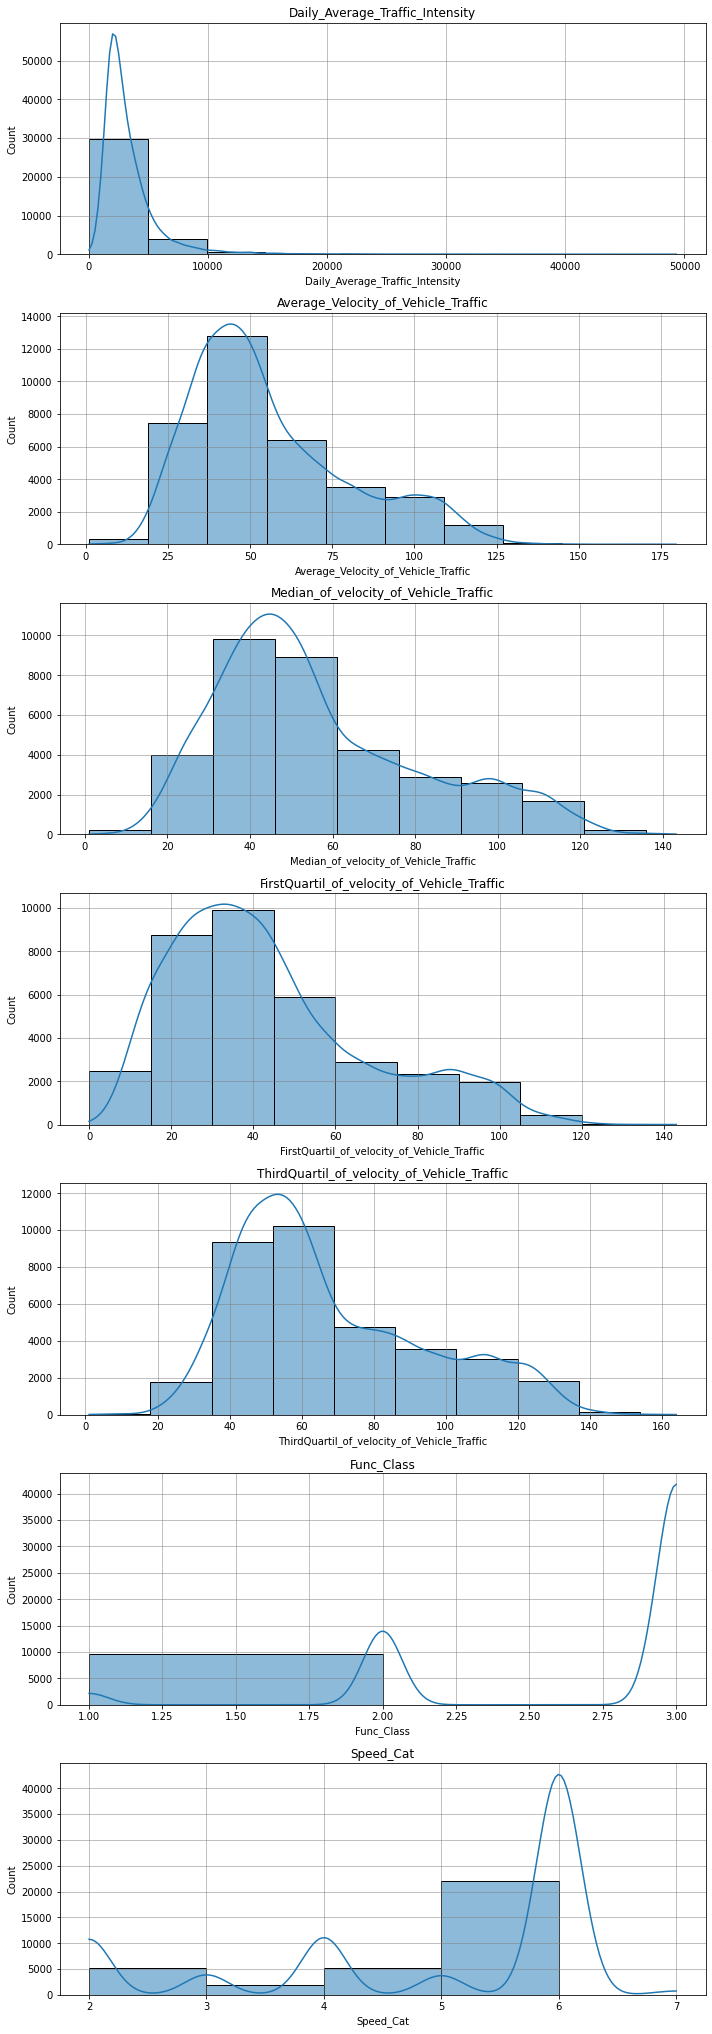

In [17]:
plt.figure(figsize=(10,40))

for c, i in enumerate(df_cl.columns.drop('linkid')):
    grid = (int(df_cl[i].min()), int(df_cl[i].max()))
    rng = (int(df_cl[i].max())-int(df_cl[i].min()))
    plt.subplot(10,1,c+1, ).grid(True, linewidth=0.5, color='grey', linestyle='-')
    sns.histplot(df_cl[i], bins=range(grid[0], grid[1], math.ceil(rng/10)), kde=True)
    plt.title(i)
    plt.tight_layout()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
linkid,1.000000,0.037559,0.048862,0.053640,0.042101,0.054858,0.016029,-0.065205
Daily_Average_Traffic_Intensity,0.037559,1.000000,0.023693,0.035433,0.004296,0.042007,-0.111363,-0.104157
Average_Velocity_of_Vehicle_Traffic,0.048862,0.023693,1.000000,0.978620,0.955459,0.966276,-0.636678,-0.771707
Median_of_velocity_of_Vehicle_Traffic,0.053640,0.035433,0.978620,1.000000,0.957067,0.966519,-0.639230,-0.784730
FirstQuartil_of_velocity_of_Vehicle_Traffic,0.042101,0.004296,0.955459,0.957067,1.000000,0.897835,-0.593372,-0.738564
ThirdQuartil_of_velocity_of_Vehicle_Traffic,0.054858,0.042007,0.966276,0.966519,0.897835,1.000000,-0.648758,-0.778613
Func_Class,0.016029,-0.111363,-0.636678,-0.639230,-0.593372,-0.648758,1.000000,0.642459
Speed_Cat,-0.065205,-0.104157,-0.771707,-0.784730,-0.738564,-0.778613,0.642459,1.000000


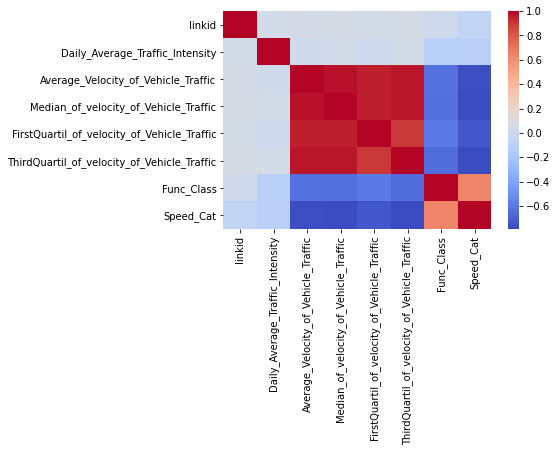

In [18]:
corr = df_cl.corr()
sns.heatmap(corr, cmap='coolwarm')
corr

In [19]:
df_cl

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
0,80216819,6224.778569,45.208716,44.464286,28.000000,59.00,2,6
1,80216858,2236.054168,79.563308,82.750000,71.750000,93.25,2,4
2,80216859,2138.725039,65.955069,67.333333,61.000000,75.00,3,6
3,80216860,2201.335041,47.533911,44.000000,26.900000,74.00,3,6
4,80216867,2102.610278,51.375291,53.250000,45.333333,59.00,3,6
...,...,...,...,...,...,...,...,...
34673,1223266734,2301.997364,44.392857,43.500000,37.000000,50.00,3,4
34674,1223277122,1655.507135,106.848684,109.500000,88.000000,124.00,2,3
34675,1223277123,1665.608140,108.863821,114.250000,90.000000,124.50,2,3
34676,1223277124,2580.645483,104.774517,108.375000,94.200000,122.00,2,3


# Interpreting the data

In [20]:
df_speed = df_cl.groupby('Speed_Cat').mean().drop(columns=['linkid', 'Func_Class'])
df_road = df_cl.groupby('Func_Class').mean().drop(columns=['linkid', 'Speed_Cat'])

In [21]:
df_speed

,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic
Speed_Cat,,,,,
2,3664.286540,95.592143,97.103793,81.794697,111.052027
3,4233.880542,78.436224,80.727134,63.453843,94.431314
4,3509.128006,60.429283,61.469174,48.430564,72.842590
5,4074.533842,59.782271,60.816523,47.728054,72.178943
6,3085.426772,43.034837,42.565204,31.231030,53.444399
7,2456.823950,37.079491,37.242100,27.694990,45.590936


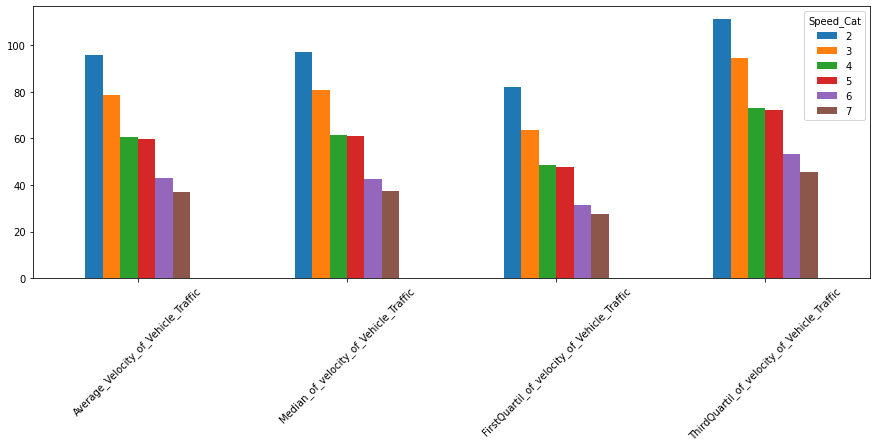

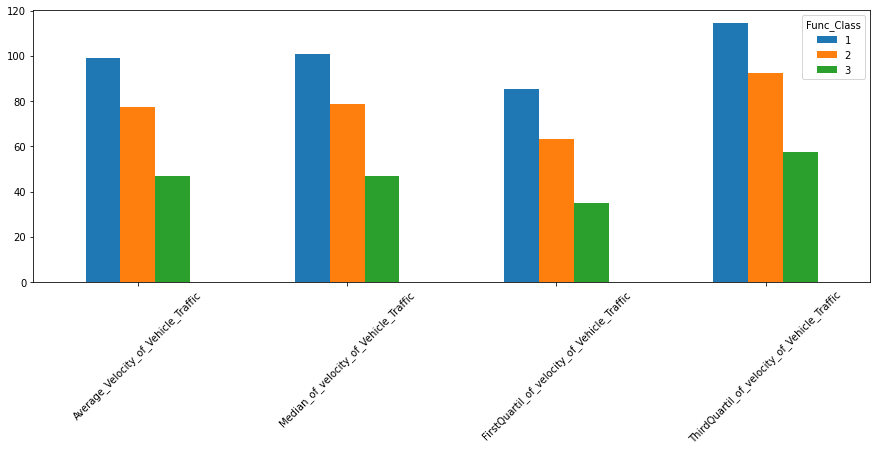

In [22]:
# displaying the relation within the road classes and speed classes
df_speed.drop(columns='Daily_Average_Traffic_Intensity').T.plot(figsize=(15,5), kind='bar')
plt.xticks(rotation=45)
plt.show()

df_road.drop(columns='Daily_Average_Traffic_Intensity').T.plot(figsize=(15,5), kind='bar')
plt.xticks(rotation=45)
plt.show()

2


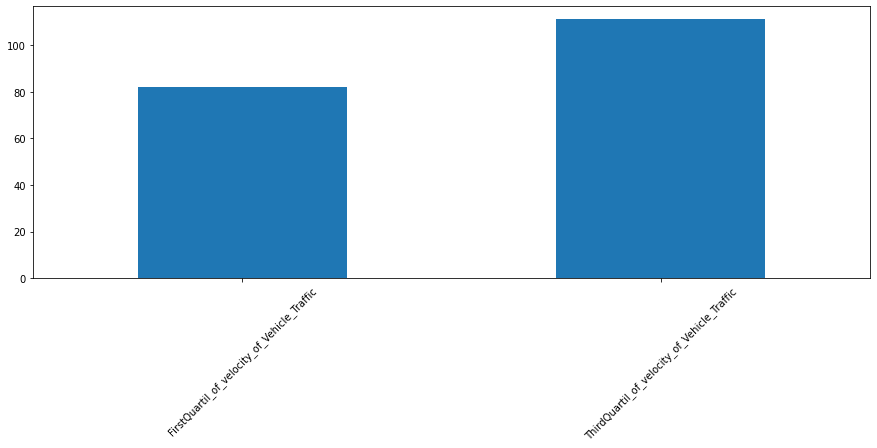

3


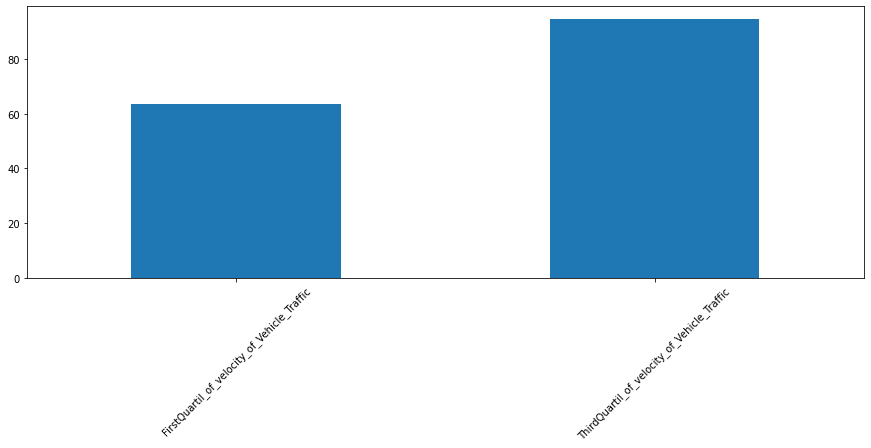

4


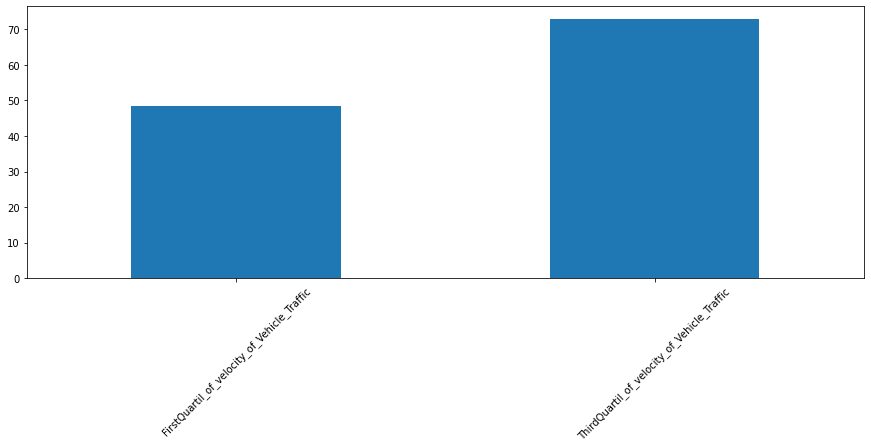

5


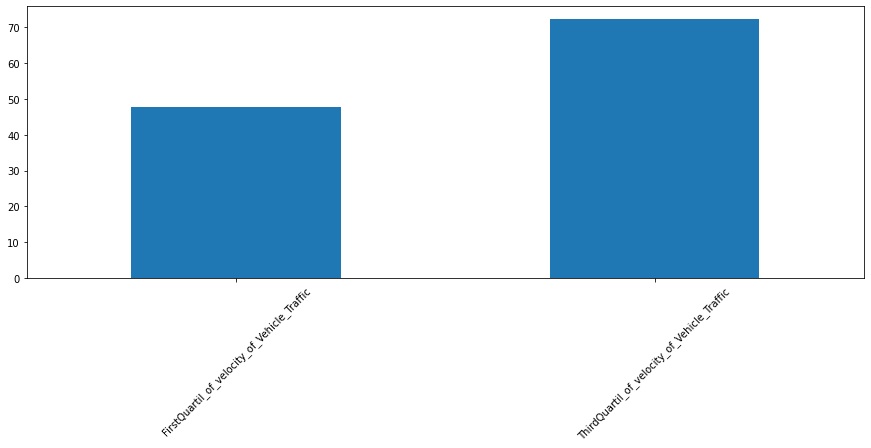

6


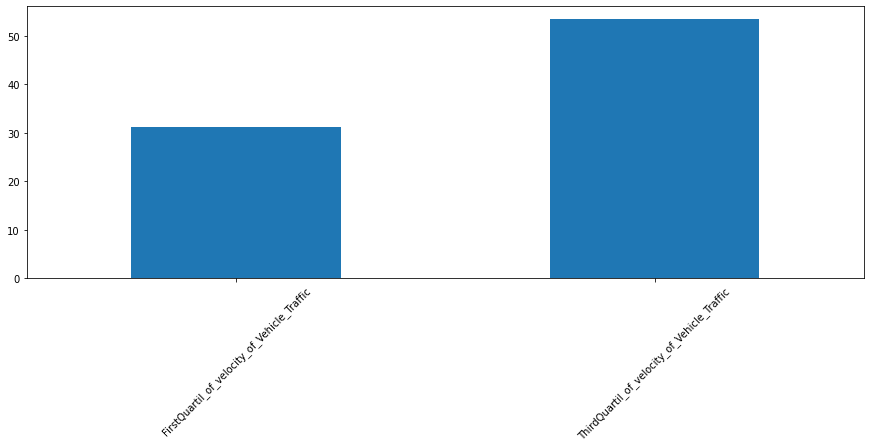

7


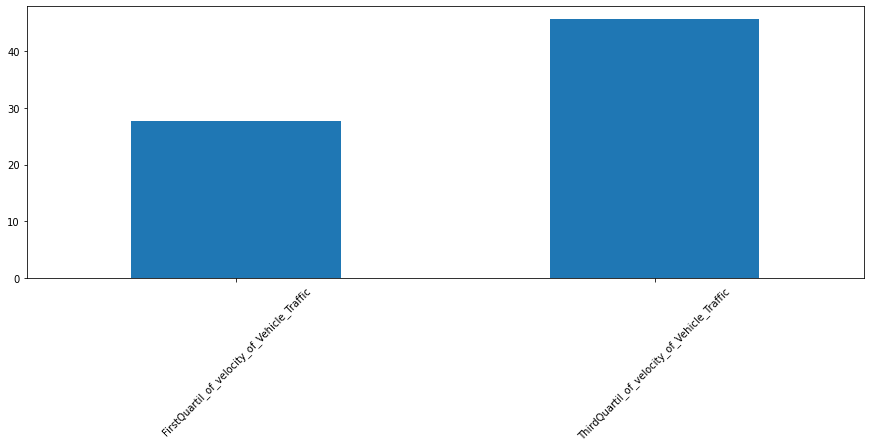

In [23]:
# showing the differences in distribution of the different speed cats
for cat in df_speed.index:
    print(cat)
    df_speed.loc[cat,['FirstQuartil_of_velocity_of_Vehicle_Traffic', 'ThirdQuartil_of_velocity_of_Vehicle_Traffic']].T.plot(figsize=(15,5), kind='bar')
    plt.xticks(rotation=45)
    plt.show()

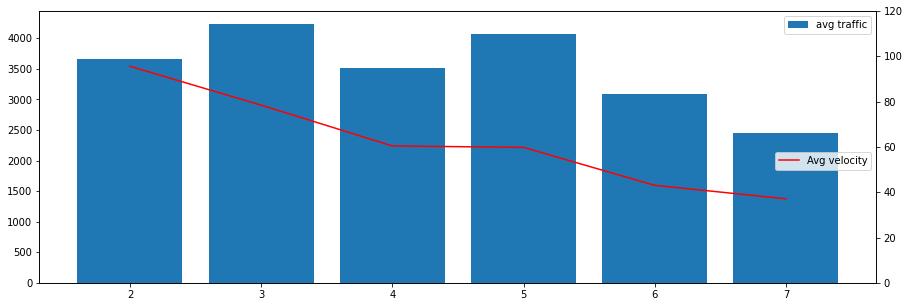

In [24]:
# displaying the relation of traffic within the road classes and speed classes

plt.figure(figsize=(15,5))
plt.bar(df_speed.index, df_speed['Daily_Average_Traffic_Intensity'], label='avg traffic')
plt.legend()
ax2 = plt.twinx()
ax2.plot(df_speed['Average_Velocity_of_Vehicle_Traffic'], color='r', label='Avg velocity')
ax2.set_ylim(0,120)
ax2.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
## finding: The fastest roads DON'T have the biggest traffic turnover!!
## the avg speed for speed class 4 and 5 is the same even though there is less traffic on cat 4! They could be aligned or traffic should be shifted.
# 4	71-90 km/h
# 5	51-70 km/h




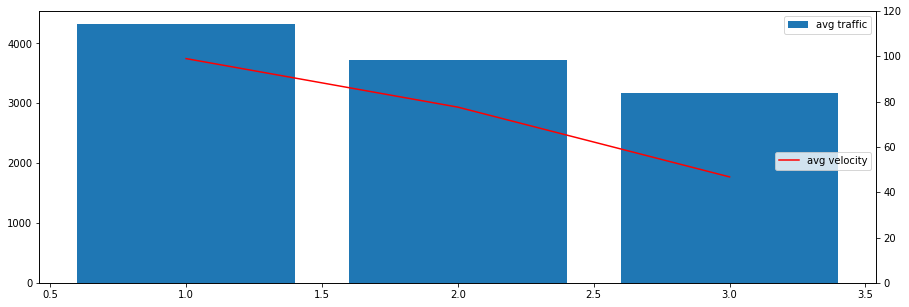

In [25]:
plt.figure(figsize=(15,5))
plt.bar(df_road.index, df_road['Daily_Average_Traffic_Intensity'], label='avg traffic')
plt.legend()
ax4 = plt.twinx()
ax4.plot(df_road['Average_Velocity_of_Vehicle_Traffic'], label='avg velocity', color='r')
ax4.set_ylim(0,120)
ax4.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
# finding: the biggest roads have the highest traffic turnover,
# speed is in accordance to the road class

In [26]:
# do the fastest roads have the best infrastructure?
corr = df_cl[['Func_Class', 'Speed_Cat']].corr()
corr
## only 65% speedability can be explained by the road class and vice versa

,Func_Class,Speed_Cat
Func_Class,1.000000,0.642459
Speed_Cat,0.642459,1.000000


In [27]:
# which roads are good/big, but have an unusual speed restriction?
df_rd_spd = df_cl[['linkid', 'Func_Class', 'Speed_Cat']]

In [28]:
df_rd_spd['diff'] = df_rd_spd['Func_Class']/3 - df_rd_spd['Speed_Cat']/7

<ipython-input-28-9de918ebb338>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_spd['diff'] = df_rd_spd['Func_Class']/3 - df_rd_spd['Speed_Cat']/7


In [29]:
diff_geo = df_rd_spd.sort_values(by='diff', ascending=False).head(100).merge(geo[['linkid', 'geometry']], on="linkid")

In [30]:
diff_geo
# this set of 100 examples shows roads where the speed limit is 120 kph but the functional class is equal to:
# These roads interconnect First Class Roads (FRC2) and provide a high volume of traffic movement at a lower level of mobility than First Class Roads (FRC2).

,linkid,Func_Class,Speed_Cat,diff,geometry
0,912804996,3,2,0.714286,"MULTILINESTRING ((-8.47544 41.01511, -8.47567 ..."
1,1202634529,3,2,0.714286,"MULTILINESTRING ((-9.19378 38.62870, -9.19390 ..."
2,920289406,3,2,0.714286,"MULTILINESTRING ((-9.10075 38.60752, -9.10098 ..."
3,1202629369,3,2,0.714286,"MULTILINESTRING ((-9.20133 38.64054, -9.20139 ..."
4,1202629370,3,2,0.714286,"MULTILINESTRING ((-9.20161 38.64316, -9.20158 ..."
...,...,...,...,...,...
95,588620051,3,2,0.714286,"MULTILINESTRING ((-8.70927 41.32472, -8.70935 ..."
96,916306011,3,2,0.714286,"MULTILINESTRING ((-8.94696 38.67673, -8.94643 ..."
97,588620050,3,2,0.714286,"MULTILINESTRING ((-8.70803 41.32417, -8.70818 ..."
98,917340259,3,2,0.714286,"MULTILINESTRING ((-8.94284 38.68102, -8.94254 ..."


In [31]:
sm = folium.Map([38.74288, -9.16624])

for c, row in diff_geo.iterrows():
    folium.Choropleth(row['geometry'], line_weight=7, line_color='blue').add_to(sm)

sm